## Sequential perturbations

Winter 2025

Alan M H Beem

<!-- # TODO make it like one population of BN act on another, and second population actuates DFA of acted-on BN
Immune cells act on cancer cells in immunotherapy

Do they leave something behind? micropeptides? -->

In [1]:
# setup
N = 40
# K = 2
from package.abn_mir_helper_functions import *
from package.abn_mir_plotting_functions import select_network
from package.bn_graph_methods import *
from package.plotting import get_colors, binary_states, bv_histogram
from random import SystemRandom as rand
from seq_pert_as_py import seq_pert_report, control_report

#### Problem specification:

Find a sequence of unit perturbations (p1, p2) such that for all cycles there exists an interval L such that a run-in from the perturbed state (i.e. p1 has been applied, L steps have occurred, and p2 has been applied) would terminate in cycle detection of the goal cycle.

---

Secondarily, let the Boolean network be a deterministic finite automaton that detects the goal cycle states and prevents further perturbation (in an applied model this could be something like cell death or apoptosis, for example).

---
Further,

Let there be a 5% chance of unit perturbation;

Alternatively,

Let there be a % chance of unit perturbation that is also a function of total change in Boolean states  / |nodes| per step; proportional to total change / |nodes| or 1/total change / |nodes|

#### Solution method:

#### Adjacency matrix from transitions matrix

After forming an adjacency matrix (with a 1 for each non-zero entry of the transitions matrix, and a 0 otherwise), by raising the matrix to successively higher powers, starting from 1, we could determine whether the goal states (cycle) are reachable from all other cycles, in some number of perturbations (the values of the non-zero entries after multiplication).

But for this:

Algorithm:

best sequences <- list

For each perturbable node, form a matrix _A<sub>p<sub>k</sub></sub>_, with elements _a<sub>i,j</sub>_, 1 if perturbation of node _k_ causes a network in state _i_ to transitions to state _j_, otherwise 0.

For all ordered pairs of matrices A<sub>p<sub>k</sub></sub>:

Does A<sub>p<sub>k<sub>1</sub></sub></sub> $*$ A<sub>p<sub>k<sub>2</sub></sub></sub> have all non-zero entries in the column of goal cycle index, for all rows except the row of goal cycle index?  | In retrospect, it would be good to include that row.

If so, there does exist such a sequence of perturbations, separated by an interval L: 0 ≤ L ≤ longest cycle length - 1, such that applying p1, waiting L steps, and applying p2 will result in a goal state.

Otherwise, which sequence has the most in the column for the goal cycle? or, the greatest sum in the column for the goal cycle?

### Set up a network for which to search for sequential perturbations effecting goal states

In [2]:
net = select_network(
    num_nodes=N,
    minimum_max_cycle_length=15,
    maximum_max_cycle_length=35,
    minimum_number_of_cycles=10,
    maximum_number_of_cycles=30,
    maximum_number_of_networks=1024,
    iterations_limit=400,
)[
    0
]  # select net also returns all generated nets, used in bool_main for appendix figures
net.add_cycles(1000)
print(net)
net.compute_unit_perturbations_matrix(sort_selection=1, compute_over_t_u=False)
setup_colors = get_colors(
    len(net.bn_collapsed_cycles) + 10, True
)  # [[1, 1, 1, 1]]  # [[0.3, 0.3, 0.3, 0.5]]
avg_color = [
    sum(setup_colors[i][0] for i in range(len(setup_colors))) / len(setup_colors),
    sum(setup_colors[i][1] for i in range(len(setup_colors))) / len(setup_colors),
    sum(setup_colors[i][2] for i in range(len(setup_colors))) / len(setup_colors),
    sum(setup_colors[i][3] for i in range(len(setup_colors))) / len(setup_colors) / 10,
]
setup_colors.append(avg_color)

BooleanNetwork: N=40. avg_k= 1.75. Run-ins: 1202. Observed cycles: 35. t_records: 1202. u_records: 0
Cycle lengths: [30, 30, 30, 22, 21, 15, 15, 15, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 2, 2, 1, 10, 5, 7, 11, 5, 3, 5, 10]


#### Cycle states as binary numbers (left), goal cycle states as binary values (right; white: off, black: on)
Each state is taken to be a binary integer (ex: for N=2, a state 01<sub>2</sub> -> 1, a state 11<sub>2</sub> -> 3)

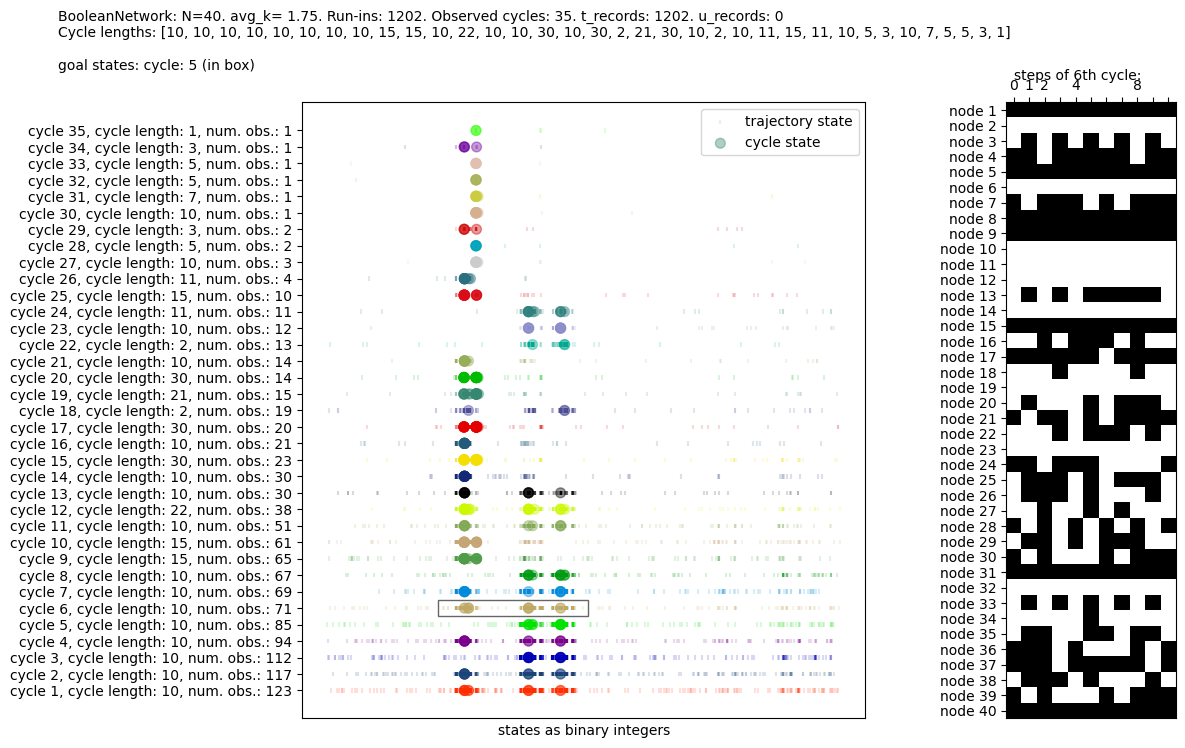

In [3]:
# goal states as a given cycle
goal_cycle_index = rand().randrange(0, len(net.bn_collapsed_cycles.cycle_records))
fig = binary_states(net, setup_colors, goal_cycle_index, plt)
plt.show()

#### Run-ins colored by cycle index without perturbation, without noise:

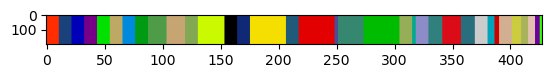

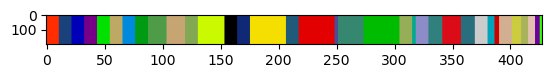

In [4]:
fig1, fig2 = control_report(
    net=net,
    cycle_colors=setup_colors,
    total_steps=200,
    progress_div=1,
    frequency_stacked=True,
    with_noise=False,
)
plt.show()

#### Run-ins colored by cycle index without perturbation, with noise:

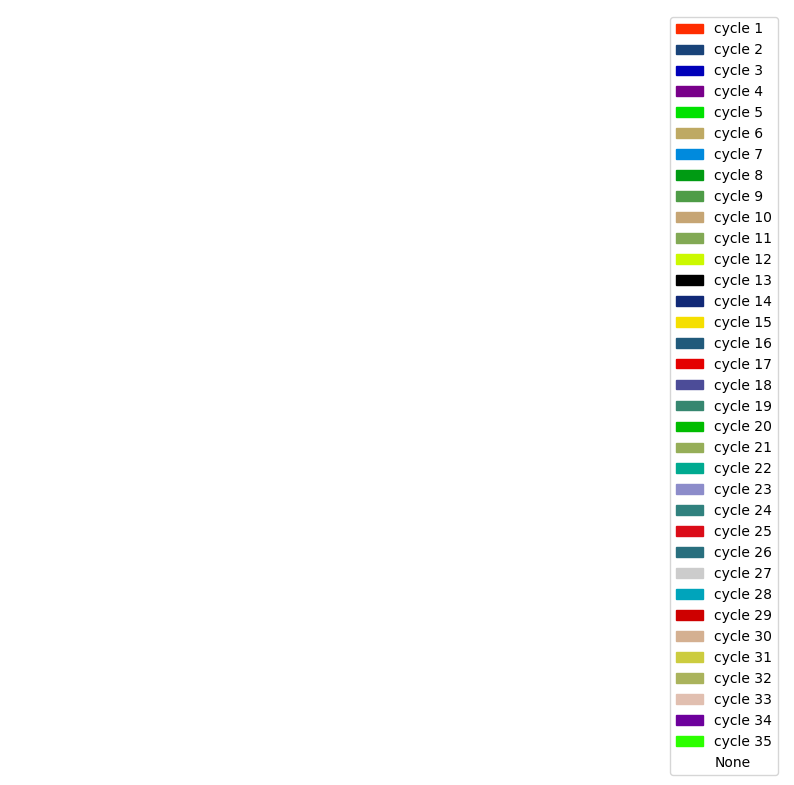

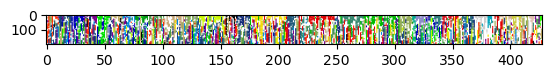

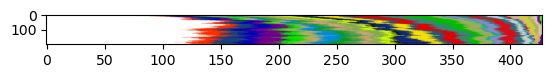

In [5]:
fig1, fig2 = control_report(
    net=net,
    cycle_colors=setup_colors,
    total_steps=200,
    progress_div=1,
    frequency_stacked=True,
    with_noise=0.05,
    show_legend=True
)
plt.show()

#### Applying algorithm to find a perturbation composed of two unit perturbations (=flipping the state of one bit)
Interval L then varies over finite state machine operation

In [6]:
matrices = [
    np.zeros_like(net.cycles_unit_perturbations_transition_matrix) for _ in net.nodes
]
all_matrix = np.zeros_like(net.cycles_unit_perturbations_transition_matrix)
for record in net.cycles_unit_perturbations_records:
    if record.end_index is not None:
        matrices[record.perturbed_node_index][record.start_index][
            record.end_index
        ] = 1  # 1 represents adjacency
        all_matrix[record.start_index][
            record.end_index
        ] = 1  # 1 represents adjacency  # this one is for a secondary question
max_good_rows = 0
found_sequences_2 = []
# working_sequences_2 = []  # initial output -> thoughts: requiring that the perturbation not make the goal state change is important, but may be overly restrictive
best_sequence = None
for i in range(len(matrices)):
    for j in range(len(matrices)):
        matrix_product = matrices[i] @ matrices[j]
        good_rows = 0
        for row in matrix_product:
            # if matrix_product[L][goal_cycle_index] == max(row):
            # # if row[goal_cycle_index] > 0:
            #     good_rows += 1
            good_rows += 1  # row[goal_cycle_index] / sum(row)
        if good_rows == len(net.bn_collapsed_cycles) - 1:
            found_sequences_2.append((i, j))
        if good_rows > max_good_rows:
            max_good_rows = good_rows
            best_sequence = (i, j)
print(
    f"{len(found_sequences_2)} sequences of perturbations unanimously effect goal state"
)
print(
    f"results:\nsequence: {best_sequence}\nnumber of cycles for which sequence -> goal: {max_good_rows}"
)

0 sequences of perturbations unanimously effect goal state
results:
sequence: (0, 0)
number of cycles for which sequence -> goal: 36


#### Applying algorithm to find a perturbation composed of three unit perturbations (=flipping the state of one bit)
Intervals L1, L2 then vary over finite state machine operation

In [7]:
matrices = [
    np.zeros_like(net.cycles_unit_perturbations_transition_matrix) for _ in net.nodes
]
all_matrix = np.zeros_like(net.cycles_unit_perturbations_transition_matrix)
for record in net.cycles_unit_perturbations_records:
    if record.end_index is not None:
        matrices[record.perturbed_node_index][record.start_index][
            record.end_index
        ] = 1  # 1 represents adjacency
        all_matrix[record.start_index][
            record.end_index
        ] = 1  # 1 represents adjacency  # this one is for a secondary question
max_good_rows = 0
found_sequence = ''
found_sequences_3 = []
best_sequence_3 = None
# working_sequences_3 = []
for i in range(len(matrices)):
    for j in range(len(matrices)):
        m_i_j = matrices[i] @ matrices[j]
        for k in range(len(matrices)):
            matrix_product = m_i_j @ matrices[k]
            good_rows = 0
            # print(f"sum(row): {sum(row)}")
            for row in matrix_product:
                if row[goal_cycle_index] == max(row):
                # if row[goal_cycle_index] > 0:
                    good_rows += 1  # row[goal_cycle_index] / sum(r for r in row)
                
            # if good_rows == len(net.bn_collapsed_cycles) - 1:
            #     found_sequences_3.append((i, j, k))
            if good_rows > max_good_rows:
                max_good_rows = good_rows
                found_sequence = (i, j, k)
print(
    f"{len(found_sequences_3)} sequences of perturbations unanimously effect goal state"
)
print(
    f"results:\nsequence: {found_sequence}\nnumber of cycles for which sequence -> goal: {max_good_rows}"
)

0 sequences of perturbations unanimously effect goal state
results:
sequence: (0, 4, 11)
number of cycles for which sequence -> goal: 13


#### Progression of distribution of states from uniform initial conditions (1 for each cycle state), BN ≠ DFA

##### With two unit perturbations, without noise, BN ≠ DFA

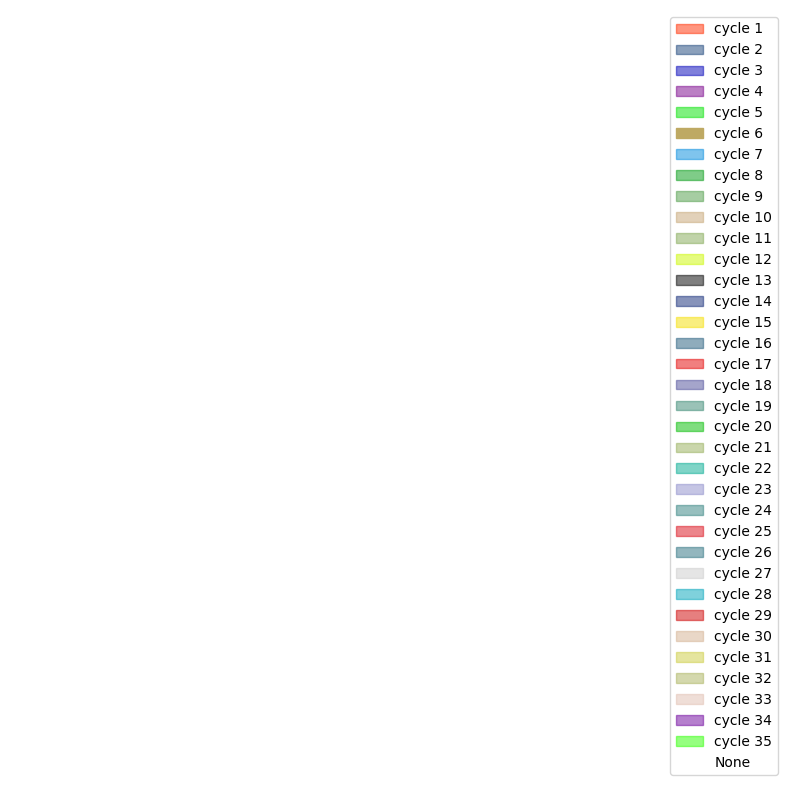

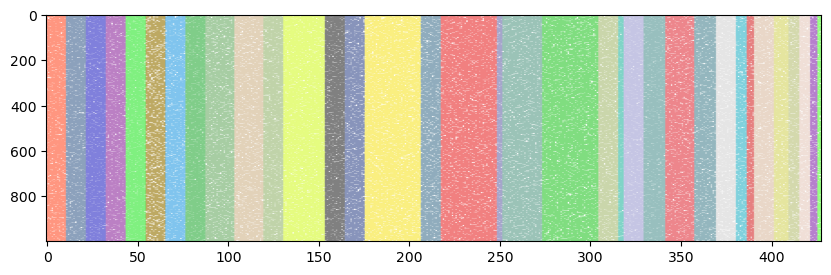

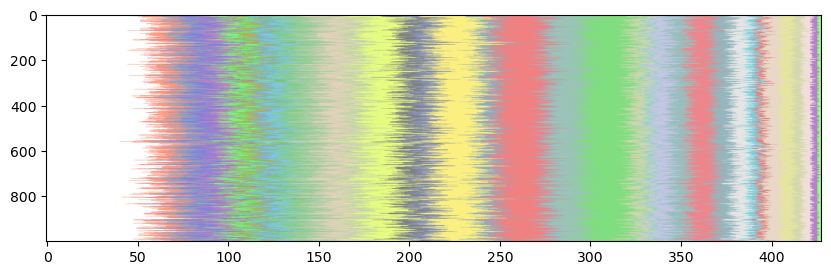

In [8]:
fig1, fig2 = seq_pert_report(
    p1=best_sequence[0],
    p2=best_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=False,
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()
# color by terminal state label

##### With three unit perturbations, without noise, BN ≠ DFA

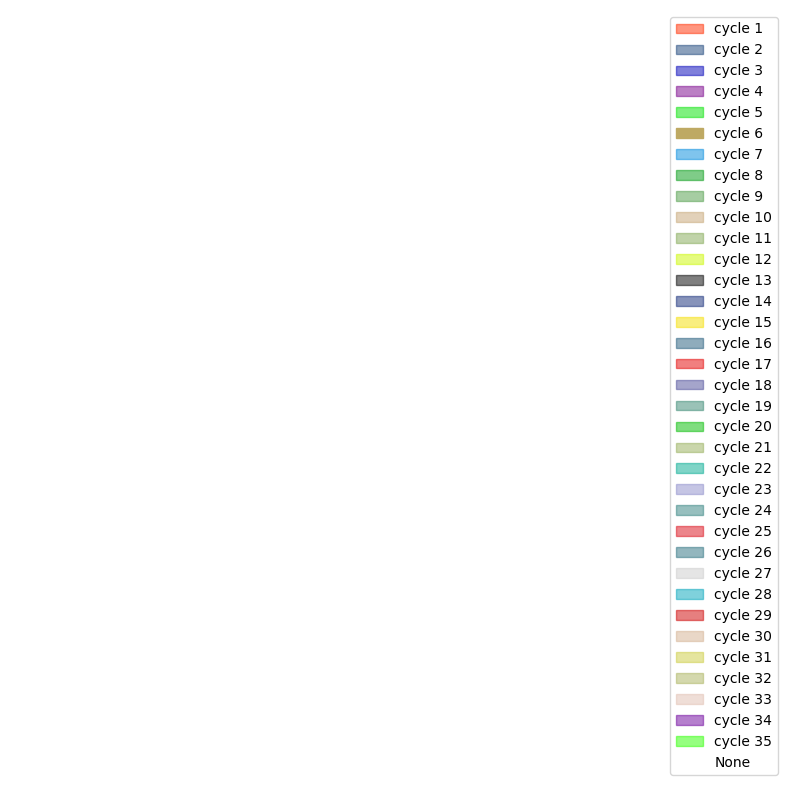

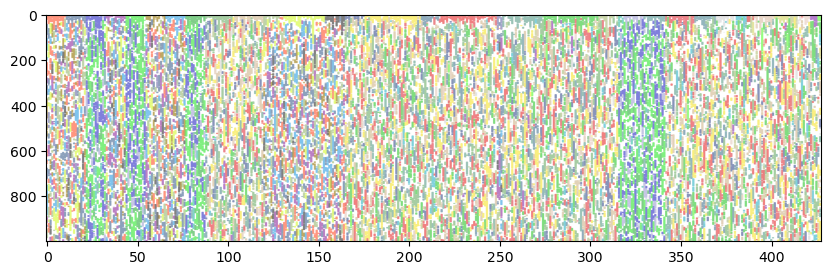

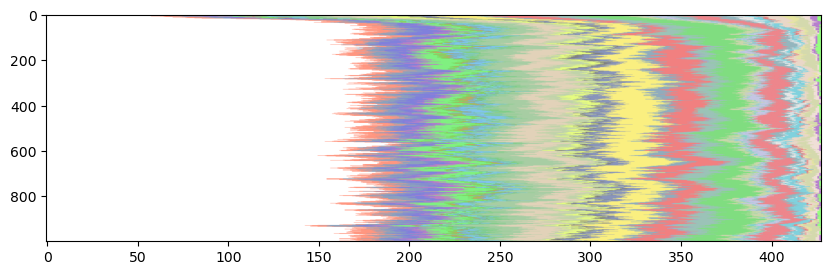

In [9]:
fig1, fig2 = seq_pert_report(
    p1=found_sequence[0],
    p2=found_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=False,
    p3=found_sequence[2],
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

#### With noise:

##### With two unit perturbations, noise, BN ≠ DFA:

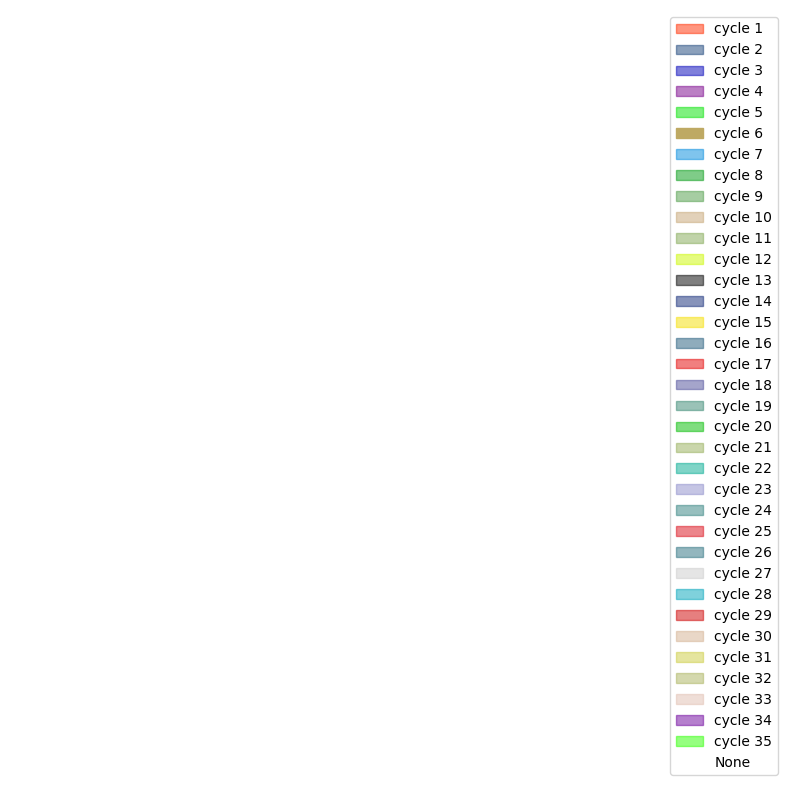

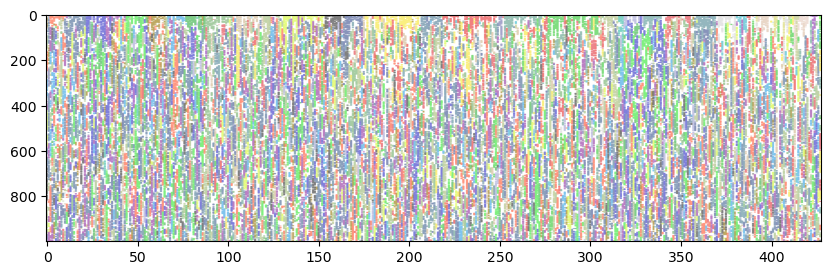

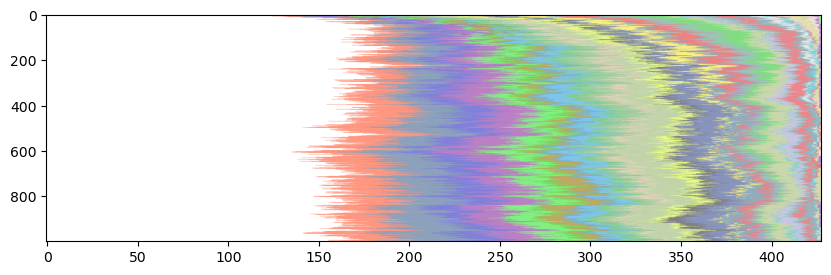

In [10]:
fig1, fig2 = seq_pert_report(
    p1=best_sequence[0],
    p2=best_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=False,
    with_noise=0.05,
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

##### With three unit perturbations, noise, BN ≠ DFA

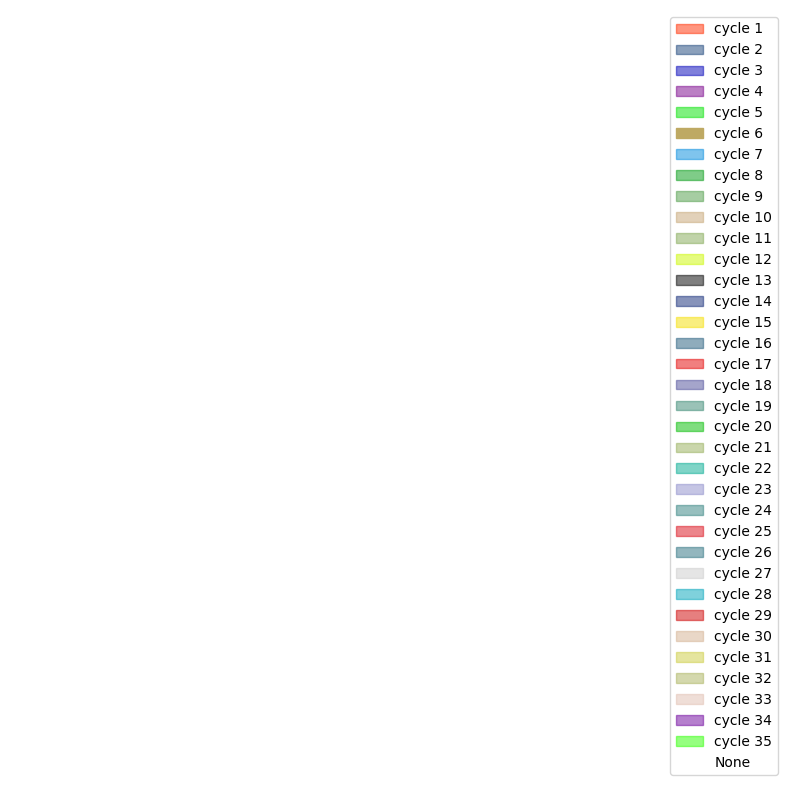

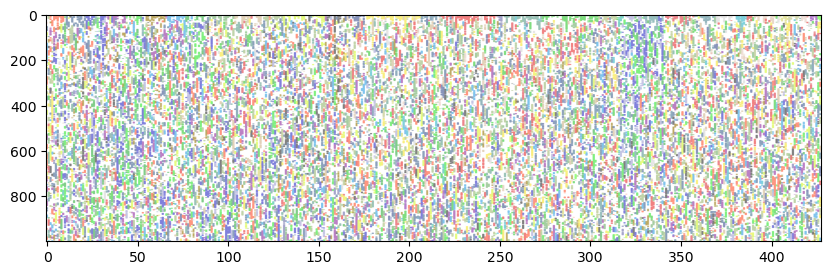

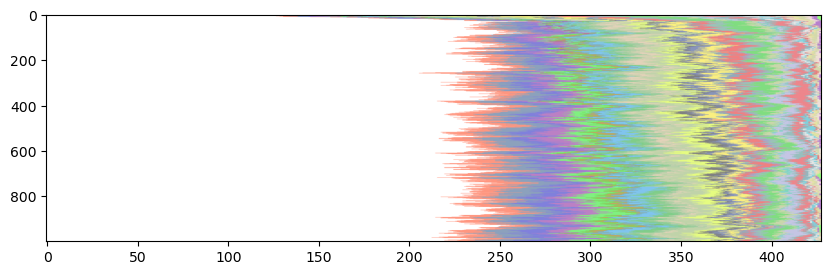

In [11]:
fig1, fig2 = seq_pert_report(
    p1=found_sequence[0],
    p2=found_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=False,
    p3=found_sequence[2],
    with_noise=0.05,
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

#### Progression of distribution of states from uniform initial conditions (1 for each cycle state), BN = DFA

##### With two unit perturbations, without noise, BN = DFA

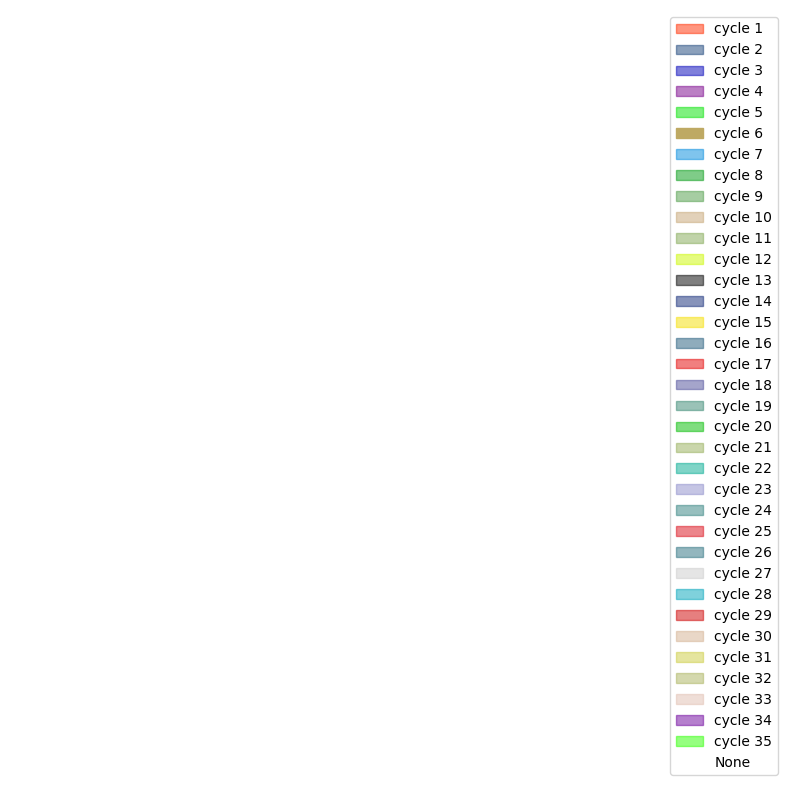

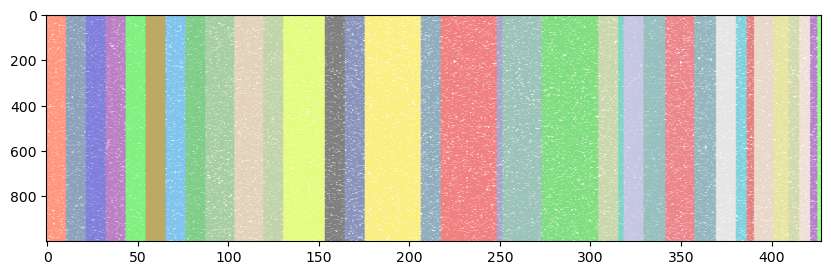

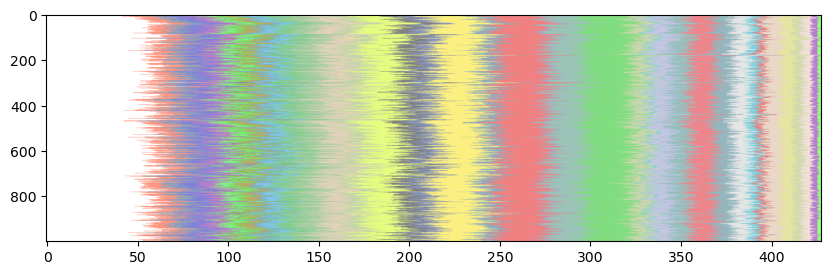

In [12]:
fig1, fig2 = seq_pert_report(
    p1=best_sequence[0],
    p2=best_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=True,
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

##### With three unit perturbations, without noise, BN = DFA

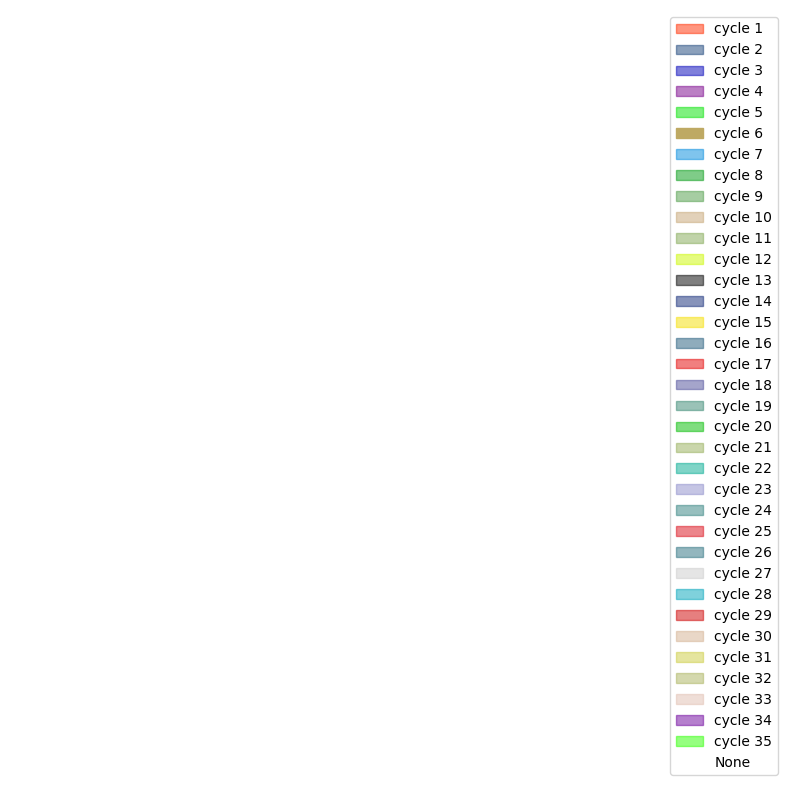

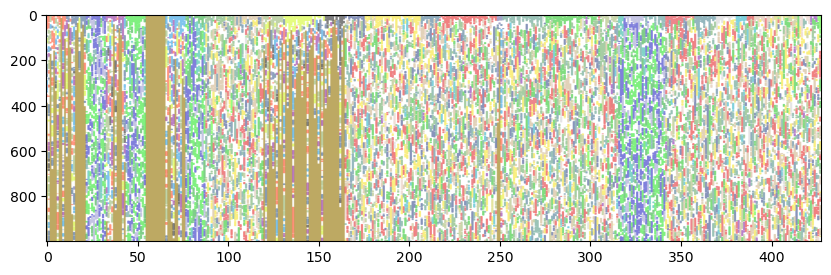

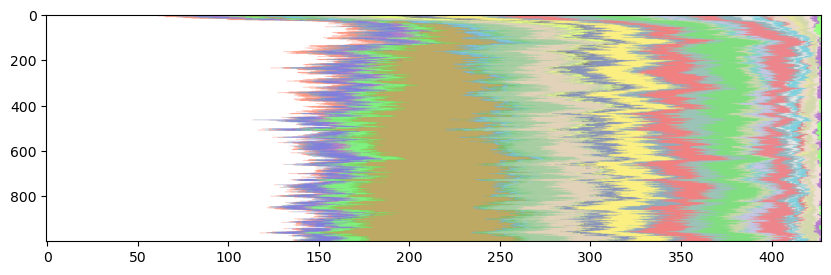

In [13]:
fig1, fig2 = seq_pert_report(
    p1=found_sequence[0],
    p2=found_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=True,
    p3=found_sequence[2],
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

#### With noise:

##### With two unit perturbations, noise, BN = DFA

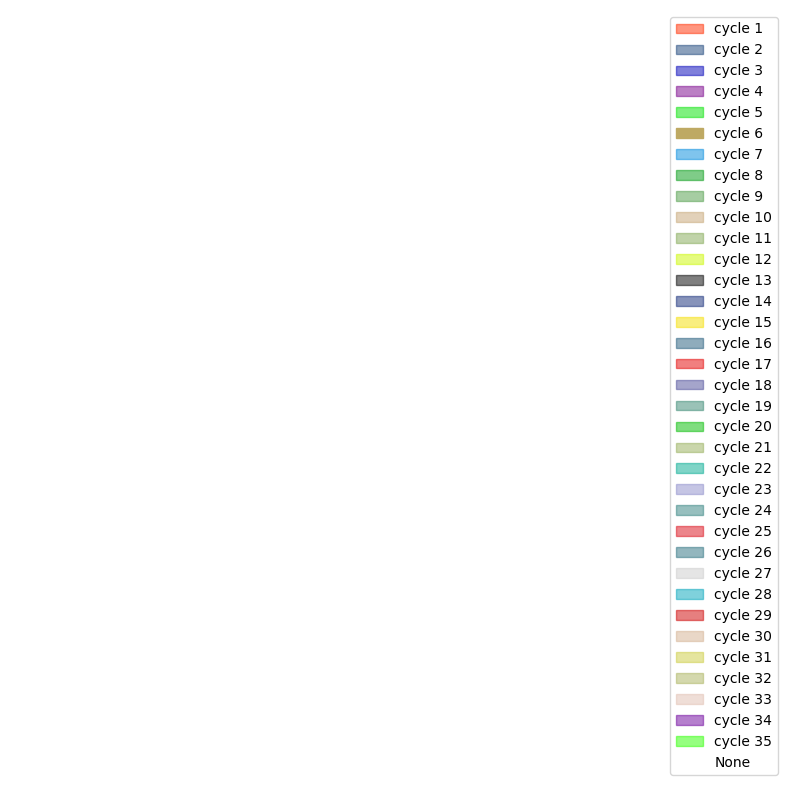

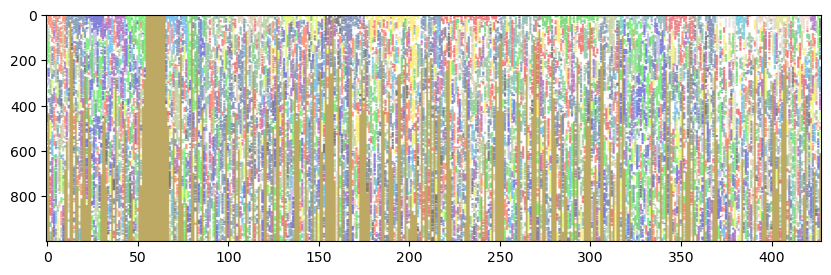

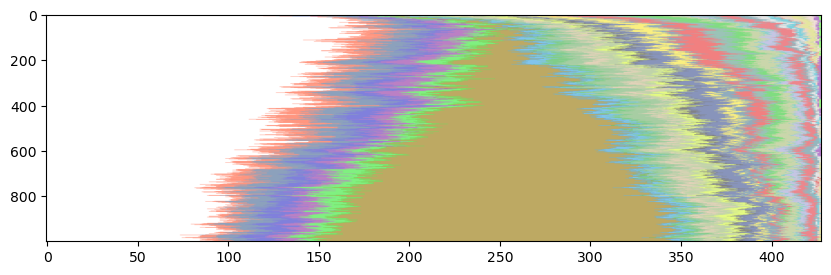

In [14]:
fig1, fig2 = seq_pert_report(
    p1=best_sequence[0],
    p2=best_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=True,
    with_noise=0.05,
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

##### With three unit perturbations, noise, BN = DFA

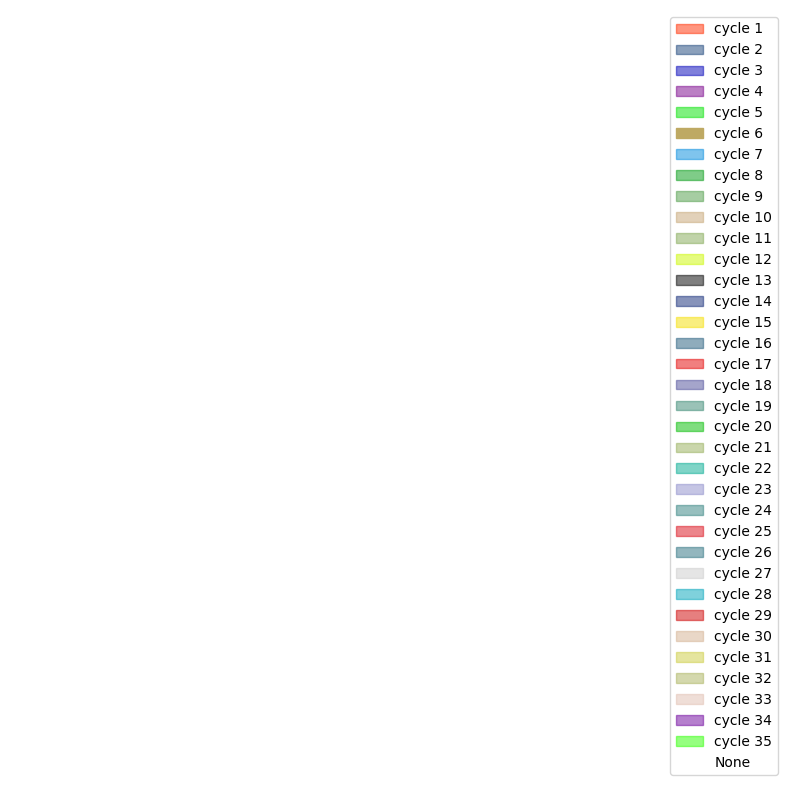

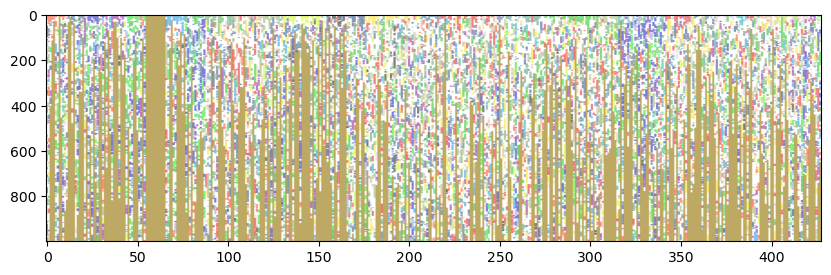

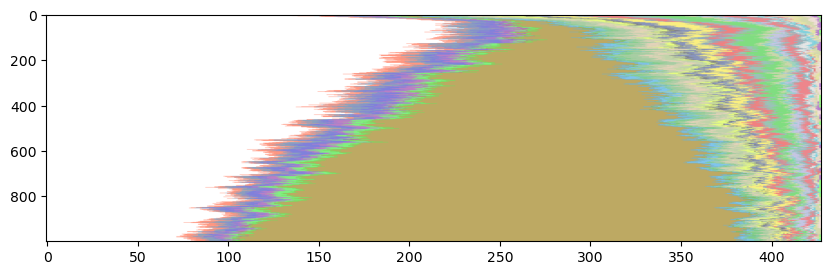

In [15]:
fig1, fig2 = seq_pert_report(
    p1=found_sequence[0],
    p2=found_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=True,  # DFA
    p3=found_sequence[2],
    with_noise=0.05,
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

#### With non-constant noise:

##### Step to step Hamming distance, or "Boolean velocity" (BV) noise (perturbations possible when more nodes are changing states):

If BV ≥ value: possible noise perturbation

##### Inverse BV noise (perturbation possible when more nodes are in constant states)

If BV < value: possible noise perturbation

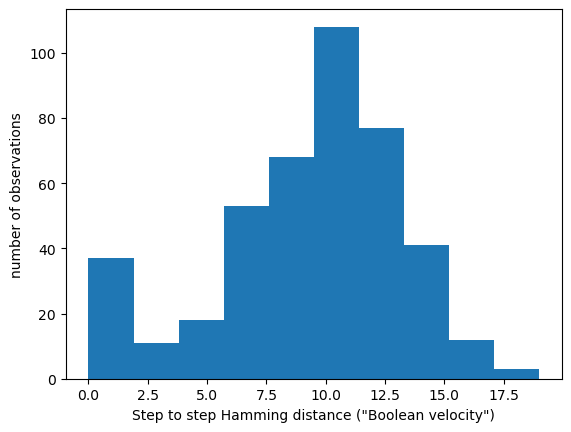

In [16]:
# histogram of BV for this network
fig = bv_histogram(net, setup_colors, stacked=False)
plt.xlabel('Step to step Hamming distance ("Boolean velocity")')
plt.ylabel('number of observations')
plt.show()

##### BV noise:
2 unit perturbations; BN = DFA

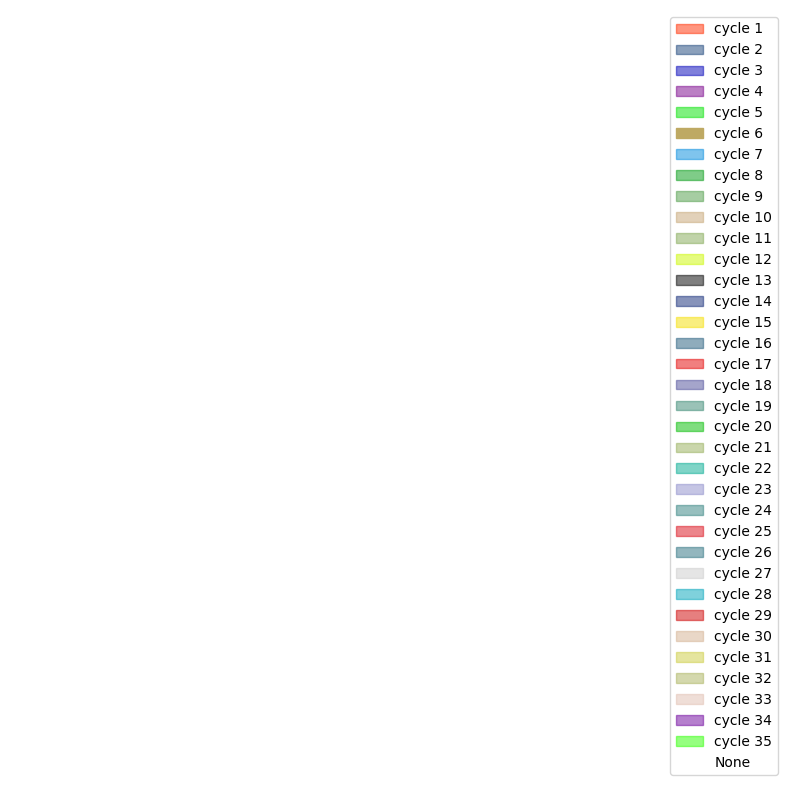

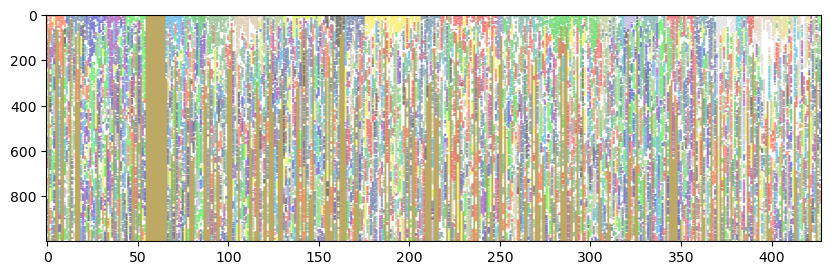

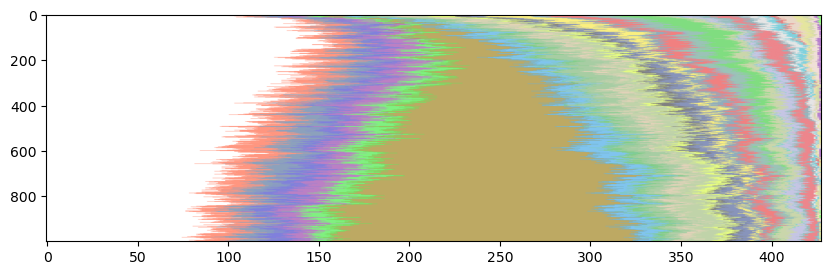

In [17]:
fig1, fig2 = seq_pert_report(
    p1=best_sequence[0],
    p2=best_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=True,  # DFA
    with_noise="inverse bv",
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

##### BV noise:
3 unit perturbations; BN = DFA

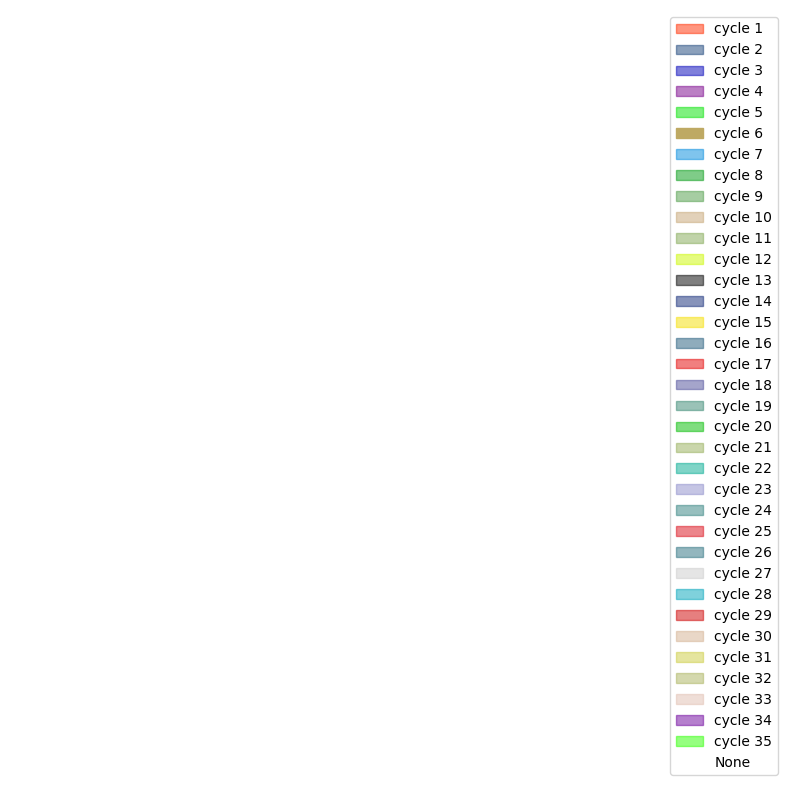

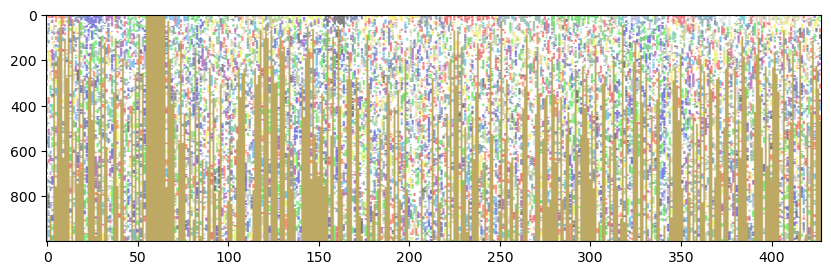

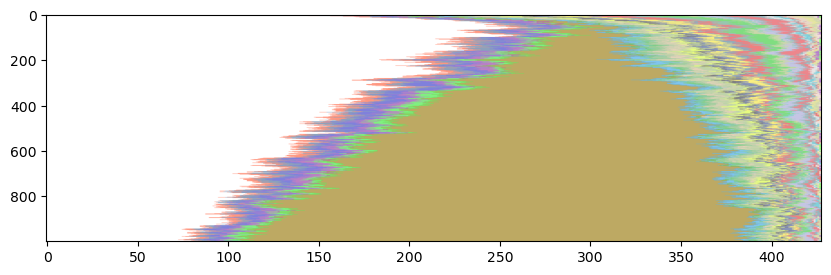

In [18]:
fig1, fig2 = seq_pert_report(
    p1=found_sequence[0],
    p2=found_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=True,  # DFA
    p3=found_sequence[2],
    with_noise="bv",
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

##### Inverse BV noise:
2 unit perturbations; BN = DFA

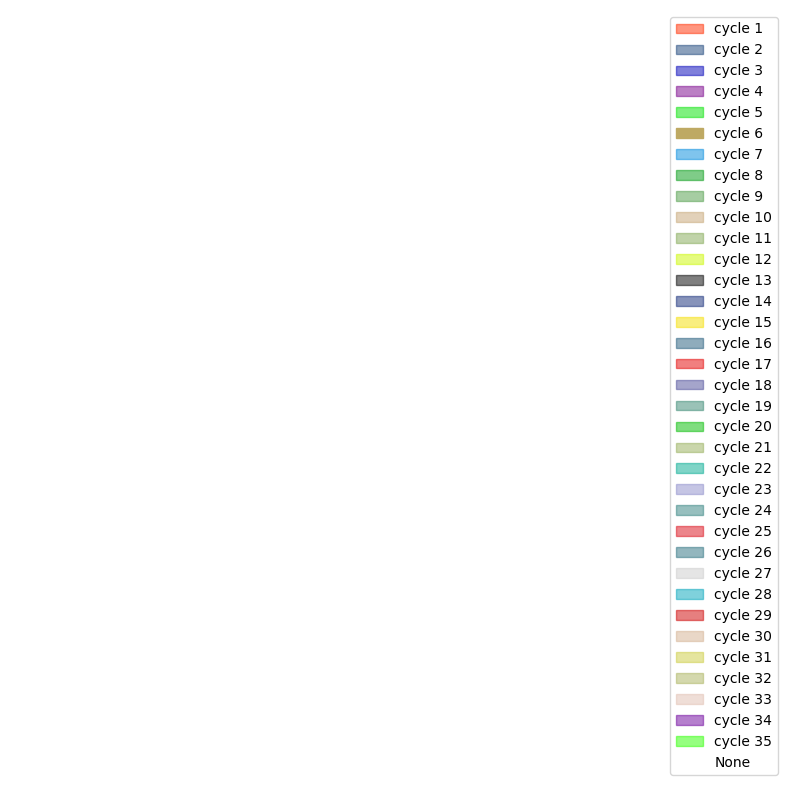

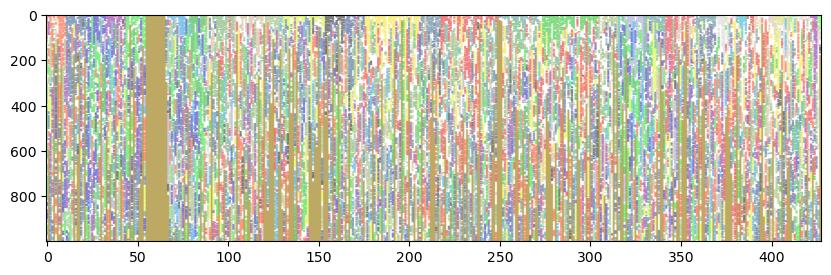

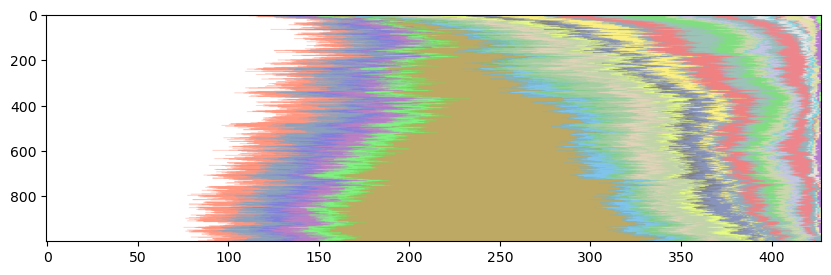

In [19]:
fig1, fig2 = seq_pert_report(
    p1=best_sequence[0],
    p2=best_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=True,  # DFA
    with_noise="inverse bv",
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()

##### Inverse BV noise:
3 unit perturbations; BN = DFA

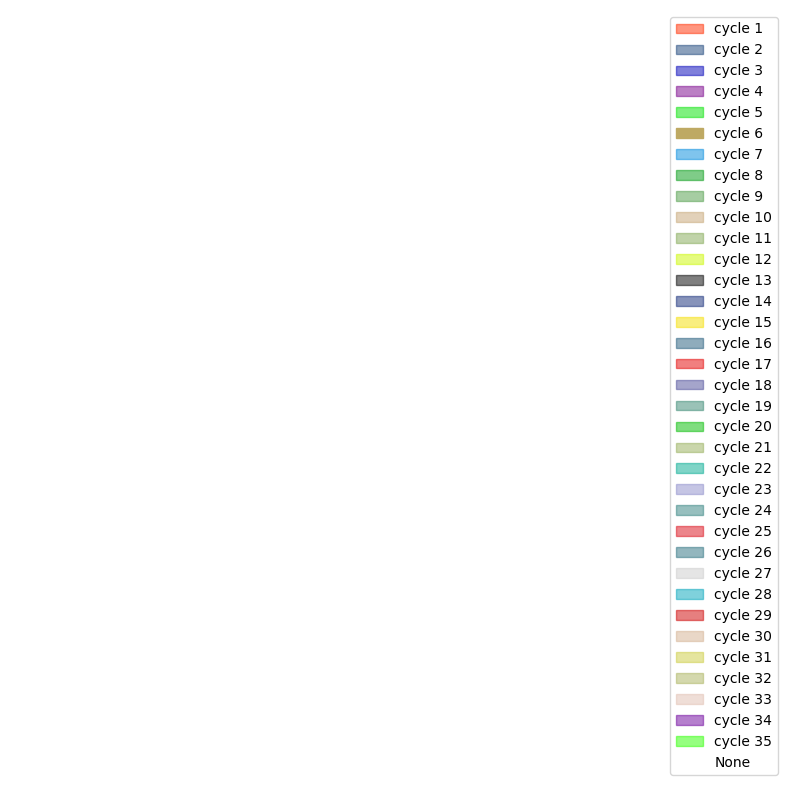

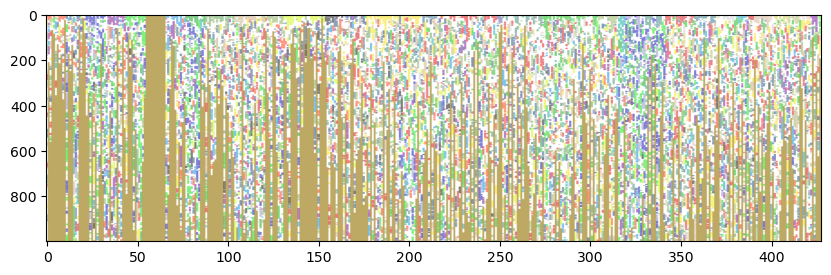

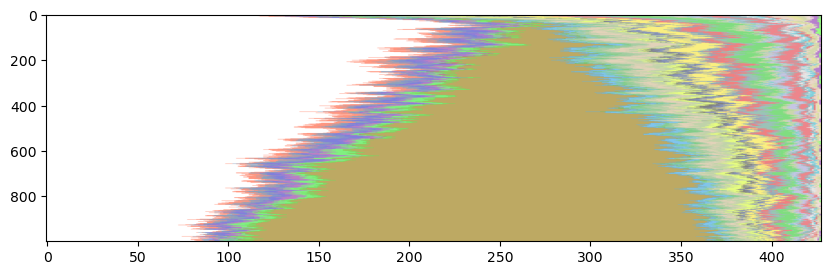

In [20]:
fig1, fig2 = seq_pert_report(
    p1=found_sequence[0],
    p2=found_sequence[1],
    goal_cycle_index=goal_cycle_index,
    net=net,
    cycle_colors=setup_colors,
    total_steps=1000,
    progress_div=1,
    goal_bool=True,  # DFA
    p3=found_sequence[2],
    with_noise="inverse bv",
    frequency_stacked=True,
)
fig1.set_size_inches(10, 30)
fig2.set_size_inches(10, 30)
plt.show()